Byte Pair Encoding (BPE) Training

In [1]:
import os
import glob
from collections import defaultdict
import gc

class BPETraining(Exception):
    def __init__(self, message):
        super().__init__(message)

class BPE:
    def __init__(self):
        self.words = []
        self.target_vocab_size = 0
        self.corpus = []
        self.vocabulary = []
        self.vocabulary_size = 0
        self.merge_rules = []

    def calculate_frequency(self, words):
        freq_dict = defaultdict(int)
        for word in words:
            freq_dict[word] += 1
        return [(word, freq_dict[word]) for word in freq_dict.keys()]

    def create_merge_rule(self, corpus):
        pair_frequencies = self.find_pair_frequencies(corpus)
        most_frequent_pair = max(pair_frequencies, key=pair_frequencies.get)
        self.merge_rules.append(most_frequent_pair.split(','))
        self.vocabulary.append(most_frequent_pair)

    def create_vocabulary(self, words):
        return list(set(''.join(words)))

    def find_pair_frequencies(self, corpus):
        pair_freq_dict = defaultdict(int)
        for word, word_freq in corpus:
            for idx in range(len(word) - 1):
                char_pair = f'{word[idx]},{word[idx+1]}'
                pair_freq_dict[char_pair] += word_freq
        return pair_freq_dict

    def get_merged_chars(self, char_1, char_2):
        return char_1 + char_2

    def initialize_corpus(self, words):
        corpus = self.calculate_frequency(words)
        return [([*word], freq) for (word, freq) in corpus]

    def merge(self, corpus):
        merge_rule = self.merge_rules[-1]
        new_corpus = []
        for word, word_freq in corpus:
            new_word = []
            idx = 0
            while idx < len(word):
                if (len(word) != 1) and (idx + 1 < len(word)) and (word[idx] == merge_rule[0]) and (word[idx+1] == merge_rule[1]):
                    new_word.append(self.get_merged_chars(word[idx], word[idx+1]))
                    idx += 2
                else:
                    new_word.append(word[idx])
                    idx += 1
            new_corpus.append((new_word, word_freq))
        return new_corpus

    def train_batch(self, words):
        self.words.extend(words)
        self.corpus.extend(self.initialize_corpus(words))
        self.vocabulary.extend(self.create_vocabulary(words))
        self.vocabulary = list(set(self.vocabulary))
        self.vocabulary_size = len(self.vocabulary)
        if self.target_vocab_size and len(self.vocabulary) > self.target_vocab_size:
            raise BPETraining(f'Error: Target vocabulary size must be greater than the initial vocabulary size ({len(self.vocabulary)})')

        while len(self.vocabulary) < self.target_vocab_size:
            try:
                self.create_merge_rule(self.corpus)
                self.corpus = self.merge(self.corpus)
                self.vocabulary = list(set(self.vocabulary))
            except ValueError:
                print('Exiting: No further merging is possible')
                break

    def finalize_training(self, target_vocab_size):
        self.target_vocab_size = target_vocab_size
        while len(self.vocabulary) < self.target_vocab_size:
            try:
                self.create_merge_rule(self.corpus)
                self.corpus = self.merge(self.corpus)
                self.vocabulary = list(set(self.vocabulary))
            except ValueError:
                print('Exiting: No further merging is possible')
                break

    def tokenize(self, text):
        tokens = [*text]
        for merge_rule in self.merge_rules:
            new_tokens = []
            idx = 0
            while idx < len(tokens):
                if (len(tokens) != 1) and (idx + 1 < len(tokens)) and (tokens[idx] == merge_rule[0]) and (tokens[idx+1] == merge_rule[1]):
                    new_tokens.append(self.get_merged_chars(tokens[idx], tokens[idx+1]))
                    idx += 2
                else:
                    new_tokens.append(tokens[idx])
                    idx += 1
            tokens = new_tokens
        return tokens

Processing Cluster Files

In [2]:
def read_abstracts_from_file(file_path):
    with open(file_path, "r") as file:
        abstracts = file.readlines()
    return [abstract.strip() for abstract in abstracts]

def process_cluster_files(cluster_dir, target_vocab_size, batch_size=2000):
    print(f'Current working directory: {os.getcwd()}')
    cluster_dir_path = os.path.abspath(cluster_dir)
    print(f'Cluster directory path: {cluster_dir_path}')
    print(f'Files in the cluster directory: {os.listdir(cluster_dir_path)}')

    cluster_files = glob.glob(os.path.join(cluster_dir_path, "*_cluster.txt"))
    if not cluster_files:
        print(f'No cluster files found in directory: {cluster_dir_path}')
        return

    vocab_dir = os.path.join(os.path.dirname(cluster_dir_path), "vocab_Overlap")
    os.makedirs(vocab_dir, exist_ok=True)

    cluster_vocabs = {}
    for cluster_file in cluster_files:
        print(f'Processing file: {cluster_file}')
        abstracts = read_abstracts_from_file(cluster_file)
        if not abstracts:
            print(f'No abstracts found in file: {cluster_file}')
            continue

        bpe = BPE()
        for i in range(0, len(abstracts), batch_size):
            batch_abstracts = abstracts[i:i+batch_size]
            batch_words = [word for abstract in batch_abstracts for word in abstract.split()]
            bpe.train_batch(batch_words)
            gc.collect()  # Explicitly call garbage collector

        bpe.finalize_training(target_vocab_size)

        vocab_file_name = os.path.basename(cluster_file).replace("_cluster.txt", "_vocab.txt")
        vocab_file_path = os.path.join(vocab_dir, vocab_file_name)
        with open(vocab_file_path, "w") as vocab_file:
            for vocab_word in bpe.vocabulary:
                vocab_file.write(vocab_word + "\n")
        print(f'Saved vocabulary to {vocab_file_path}')
        cluster_name = os.path.basename(cluster_file).replace("_cluster.txt", "")
        cluster_vocabs[cluster_name] = bpe

    return cluster_files, cluster_vocabs

def process_all_clusters_file(file_path, target_vocab_size, batch_size=2000):
    print(f'Processing all clusters file in batches: {file_path}')

    def read_abstracts_in_batches(file_path, batch_size):
        with open(file_path, "r") as file:
            batch = []
            for line in file:
                batch.append(line.strip())
                if len(batch) == batch_size:
                    yield batch
                    batch = []
            if batch:
                yield batch

    bpe = BPE()

    for batch in read_abstracts_in_batches(file_path, batch_size):
        batch_words = [word for abstract in batch for word in abstract.split()]
        bpe.train_batch(batch_words)
        gc.collect()  # Explicitly call garbage collector

    bpe.finalize_training(target_vocab_size)

    vocab_file_path = file_path.replace(".txt", "_vocab.txt")
    with open(vocab_file_path, "w") as vocab_file:
        for vocab_word in bpe.vocabulary:
            vocab_file.write(vocab_word + "\n")
    print(f'Saved vocabulary to {vocab_file_path}')
    return bpe


Tokenizing Cluster Files

In [3]:
def tokenize_clusters(cluster_files, cluster_vocabs):
    tokenized_clusters = {}
    for cluster_file in cluster_files:
        abstracts = read_abstracts_from_file(cluster_file)
        words = [word for abstract in abstracts for word in abstract.split()]
        cluster_name = os.path.basename(cluster_file).replace("_cluster.txt", "")
        bpe = cluster_vocabs[cluster_name]
        tokenized_texts = [bpe.tokenize(word) for word in words]
        tokenized_clusters[cluster_name] = set(token for tokens in tokenized_texts for token in tokens)

        print(f"Cluster {cluster_name}:")
        print(f"  Total Tokens: {len(tokenized_clusters[cluster_name])}")

    return tokenized_clusters

In [4]:
cluster_directory = "/home/ali/train_clusters"
target_vocab_size = 32000

# Process individual cluster files and obtain BPE vocabularies
cluster_files, cluster_vocabs = process_cluster_files(cluster_directory, target_vocab_size)

Current working directory: /home/ali/Tokenizer
Cluster directory path: /home/ali/train_clusters
Files in the cluster directory: ['Chemistry_cluster.txt', 'Physics_cluster.txt', 'Computer Science_cluster.txt', 'Biology_cluster.txt', 'Mathematics_cluster.txt', 'Statistics_cluster.txt']
Processing file: /home/ali/train_clusters/Chemistry_cluster.txt
Exiting: No further merging is possible
Saved vocabulary to /home/ali/vocab_Overlap/Chemistry_vocab.txt
Processing file: /home/ali/train_clusters/Physics_cluster.txt
Exiting: No further merging is possible
Saved vocabulary to /home/ali/vocab_Overlap/Physics_vocab.txt
Processing file: /home/ali/train_clusters/Computer Science_cluster.txt
Exiting: No further merging is possible
Saved vocabulary to /home/ali/vocab_Overlap/Computer Science_vocab.txt
Processing file: /home/ali/train_clusters/Biology_cluster.txt
Exiting: No further merging is possible
Saved vocabulary to /home/ali/vocab_Overlap/Biology_vocab.txt
Processing file: /home/ali/train_clus

In [5]:
all_clusters_file_path = "/home/ali/ocr_estimate/ALL_clusters.txt"
target_vocab_size = 32000
all_clusters_bpe = process_all_clusters_file(all_clusters_file_path, target_vocab_size)

Processing all clusters file in batches: /home/ali/ocr_estimate/ALL_clusters.txt
Exiting: No further merging is possible
Saved vocabulary to /home/ali/ocr_estimate/ALL_clusters_vocab.txt


Computing Pairwise Overlap

In [6]:
def compute_pairwise_overlap(tokenized_clusters):
    overlap_stats = defaultdict(dict)
    clusters = list(tokenized_clusters.keys())
    for i, cluster1 in enumerate(clusters):
        for j in range(i + 1, len(clusters)):
            cluster2 = clusters[j]
            tokens1 = tokenized_clusters[cluster1]
            tokens2 = tokenized_clusters[cluster2]
            overlap = tokens1 & tokens2
            overlap_percentage = len(overlap) / min(len(tokens1), len(tokens2)) * 100
            overlap_stats[cluster1][cluster2] = overlap_percentage
            overlap_stats[cluster2][cluster1] = overlap_percentage
            
            # Print overlap details between the two clusters
            print(f"Overlap between {cluster1} and {cluster2}: {overlap_percentage:.2f}%")
            
    return overlap_stats


Computing Overall Overlap

In [7]:
def compute_overall_overlap(tokenized_clusters):
    overall_overlap = defaultdict(int)
    for cluster_name, tokens in tokenized_clusters.items():
        for token in tokens:
            overall_overlap[token] += 1
            
    # Print overall overlap details
    print(f"Overall overlap count for tokens:")
    for token, count in overall_overlap.items():
        print(f"  Token: {token}, Count: {count}")
        
    return overall_overlap

In [8]:
tokenized_clusters = tokenize_clusters(cluster_files, cluster_vocabs)

Cluster Chemistry:
  Total Tokens: 3717
Cluster Physics:
  Total Tokens: 9540
Cluster Computer Science:
  Total Tokens: 7893
Cluster Biology:
  Total Tokens: 4487
Cluster Mathematics:
  Total Tokens: 11509
Cluster Statistics:
  Total Tokens: 3101


In [9]:
overlap_stats = compute_pairwise_overlap(tokenized_clusters)

Overlap between Chemistry and Physics: 77.97%
Overlap between Chemistry and Computer Science: 67.61%
Overlap between Chemistry and Biology: 55.64%
Overlap between Chemistry and Mathematics: 74.52%
Overlap between Chemistry and Statistics: 50.92%
Overlap between Physics and Computer Science: 55.85%
Overlap between Physics and Biology: 68.20%
Overlap between Physics and Mathematics: 47.90%
Overlap between Physics and Statistics: 73.85%
Overlap between Computer Science and Biology: 61.60%
Overlap between Computer Science and Mathematics: 52.35%
Overlap between Computer Science and Statistics: 72.85%
Overlap between Biology and Mathematics: 62.02%
Overlap between Biology and Statistics: 56.72%
Overlap between Mathematics and Statistics: 70.94%


In [10]:
overall_overlap = compute_overall_overlap(tokenized_clusters)

Overall overlap count for tokens:
  Token: sociologist, Count: 2
  Token: algorithm, Count: 6
  Token: ergodicity, Count: 3
  Token: exploration, Count: 5
  Token: hasimoto, Count: 2
  Token: pre, Count: 3
  Token: arc, Count: 4
  Token: incompatible, Count: 3
  Token: cutoff, Count: 3
  Token: tangential, Count: 3
  Token: longtime, Count: 1
  Token: shaping, Count: 3
  Token: remained, Count: 5
  Token: elliptical, Count: 3
  Token: mapped, Count: 4
  Token: cnls, Count: 1
  Token: created, Count: 6
  Token: propagate, Count: 5
  Token: phenomenology, Count: 2
  Token: conceptually, Count: 4
  Token: passing, Count: 6
  Token: directed, Count: 6
  Token: stemming, Count: 5
  Token: nonlinearity, Count: 4
  Token: best, Count: 6
  Token: characterization, Count: 5
  Token: supercriticality, Count: 1
  Token: universal, Count: 5
  Token: without, Count: 6
  Token: limitation, Count: 6
  Token: bernoulli, Count: 4
  Token: unpredictable, Count: 3
  Token: iteration, Count: 6
  Token: re

Create Final Vocab

Create a Final vocab with Pruning(Our Custom Merging Procedure) 

In [11]:
import math
def merge_cluster_vocabularies(cluster_vocabs, all_clusters_bpe, target_vocab_size, min_token_length=2):
    token_cluster_frequency = defaultdict(int)
    token_global_frequency = defaultdict(int)
    
    # Count cluster frequency and global frequency
    for cluster, vocab in cluster_vocabs.items():
        for token in vocab.vocabulary:
            token_cluster_frequency[token] += 1
            token_global_frequency[token] += sum(freq for word, freq in vocab.corpus if token in (word if isinstance(word, str) else ' '.join(word)))
    
    # Add global frequencies from all_clusters_bpe
    for token in all_clusters_bpe.vocabulary:
        token_global_frequency[token] += sum(freq for word, freq in all_clusters_bpe.corpus if token in (word if isinstance(word, str) else ' '.join(word)))
    
    # Calculate a score for each token
    token_scores = {}
    for token in token_cluster_frequency:
        if len(token) < min_token_length:
            continue
        
        cluster_coverage = token_cluster_frequency[token] / len(cluster_vocabs)
        global_freq = token_global_frequency[token]
        token_length = len(token)
        
        # Custom scoring function prioritizing longer, frequent tokens
        score= (math.log(global_freq + 1) * 0.5 + 
            cluster_coverage * 0.3 + 
            (1 / token_length) * 0.2)
        token_scores[token] = score
        
        # Log intermediate values
        print(f"Token: {token}, Cluster Coverage: {cluster_coverage}, Global Frequency: {global_freq}, Token Length: {token_length}, Score: {score}")
    
    # Sort tokens by score
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Select top tokens
    final_vocabulary = [token for token, score in sorted_tokens[:target_vocab_size]]
    
    # Iterative refinement
    combined_corpus = " ".join([word if isinstance(word, str) else ' '.join(word) for vocab in cluster_vocabs.values() for word, freq in vocab.corpus for _ in range(freq)])
    refined_bpe = BPE()
    refined_bpe.vocabulary = final_vocabulary
    refined_bpe.train_batch([combined_corpus])
    refined_bpe.finalize_training(target_vocab_size)
    
    # Pruning and replacing
    token_usage = defaultdict(int)
    for word in combined_corpus.split():
        tokens = refined_bpe.tokenize(word)
        for token in tokens:
            token_usage[token] += 1
    
    underperforming_tokens = [token for token in refined_bpe.vocabulary if token_usage[token] < len(combined_corpus.split()) / 1000]
    print(underperforming_tokens[:10])
    # Replace underperforming tokens with high-scoring tokens not in the vocabulary
    replacement_candidates = [token for token, _ in sorted_tokens if token not in refined_bpe.vocabulary]
    for i, token in enumerate(underperforming_tokens):
        if i < len(replacement_candidates):
            refined_bpe.vocabulary[refined_bpe.vocabulary.index(token)] = replacement_candidates[i]
    
    return refined_bpe.vocabulary


In [12]:

target_vocab_size = 32000
final_vocabulary = merge_cluster_vocabularies(cluster_vocabs, all_clusters_bpe, target_vocab_size)

# Save the final vocabulary to a file
output_path = "/home/ali/ocr_estimate/final_vocab__pruning32ktokenlength2.txt"
with open(output_path, 'w', encoding='utf-8') as f:
    for token in final_vocabulary:
        f.write(f"{token}\n")
print(f"Final vocabulary saved to {output_path}")

Token: local,ized, Cluster Coverage: 0.8333333333333334, Global Frequency: 0, Token Length: 10, Score: 0.27
Token: relationshi,p, Cluster Coverage: 0.16666666666666666, Global Frequency: 0, Token Length: 13, Score: 0.06538461538461537
Token: word,net, Cluster Coverage: 0.16666666666666666, Global Frequency: 0, Token Length: 8, Score: 0.075
Token: path,ological, Cluster Coverage: 0.3333333333333333, Global Frequency: 0, Token Length: 13, Score: 0.11538461538461538
Token: p,ar, Cluster Coverage: 1.0, Global Frequency: 0, Token Length: 4, Score: 0.35
Token: g,ently, Cluster Coverage: 0.16666666666666666, Global Frequency: 0, Token Length: 7, Score: 0.07857142857142857
Token: v,al, Cluster Coverage: 1.0, Global Frequency: 0, Token Length: 4, Score: 0.35
Token: gh,em, Cluster Coverage: 0.16666666666666666, Global Frequency: 0, Token Length: 5, Score: 0.09
Token: use,ful, Cluster Coverage: 1.0, Global Frequency: 0, Token Length: 7, Score: 0.32857142857142857
Token: attribu,te, Cluster Covera

Calculate metrics

In [13]:
def subword_fertility(tokenizer, words):
    total_fertility = 0
    for word in words:
        tokens = tokenizer.tokenize(word)
        total_fertility += len(tokens)
    return total_fertility / len(words) / 100 

def text_compression(tokenizer, texts):
    original_length = sum(len(text.split()) for text in texts)
    tokenized_length = sum(len(tokenizer.tokenize(text)) for text in texts)
    return original_length / tokenized_length

def mean_token_length(vocab):
    total_length = sum(len(token) for token in vocab)
    return total_length / len(vocab)

In [14]:
all_clusters_abstracts = read_abstracts_from_file(all_clusters_file_path)
all_clusters_words = [word for abstract in all_clusters_abstracts for word in abstract.split()]

In [15]:
final_bpe = BPE()
final_bpe.vocabulary = final_vocabulary
final_bpe.finalize_training(len(final_vocabulary))

In [16]:


sf_final_vocab = subword_fertility(final_bpe, all_clusters_words)
tc_final_vocab = text_compression(final_bpe, all_clusters_abstracts)
mtl_final_vocab = mean_token_length(final_vocabulary)

# Print the metrics
print(f"Subword Fertility (Final vocab): {sf_final_vocab}")
print(f"Text Compression (Final vocab): {tc_final_vocab}")
print(f"Mean Token Length (Final vocab): {mtl_final_vocab}")

Subword Fertility (Final vocab): 0.06982271087686948
Text Compression (Final vocab): 0.12557193028522665
Mean Token Length (Final vocab): 8.297561432541293


In [17]:
sf_final_vocab = subword_fertility(final_bpe, all_clusters_words)
tc_final_vocab = text_compression(final_bpe, all_clusters_abstracts)
mtl_final_vocab = mean_token_length(final_vocabulary)
sf_all_clusters = subword_fertility(all_clusters_bpe, all_clusters_words)
tc_all_clusters = text_compression(all_clusters_bpe, all_clusters_abstracts)
mtl_all_clusters = mean_token_length(all_clusters_bpe.vocabulary)


print(f"Subword Fertility (All clusters): {sf_all_clusters}")

print(f"Text Compression (All clusters): {tc_all_clusters}")

print(f"Mean Token Length (All clusters): {mtl_all_clusters}")

print("--------------------------------")

print(f"Subword Fertility (Final vocab): {sf_final_vocab}")

print(f"Text Compression (Final vocab): {tc_final_vocab}")

print(f"Mean Token Length (Final vocab): {mtl_final_vocab}")

Subword Fertility (All clusters): 0.01
Text Compression (All clusters): 0.5047211391659661
Mean Token Length (All clusters): 8.246297368152259
--------------------------------
Subword Fertility (Final vocab): 0.06982271087686948
Text Compression (Final vocab): 0.12557193028522665
Mean Token Length (Final vocab): 8.297561432541293


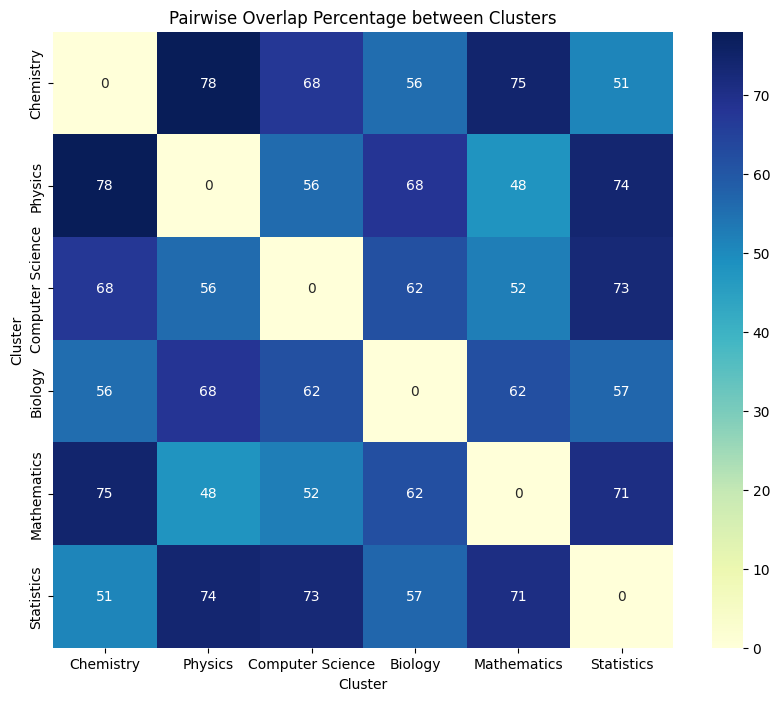

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_overlap(overlap_stats):
    # Extract cluster names and overlap percentages
    clusters = list(overlap_stats.keys())
    overlap_matrix = [[overlap_stats[cluster1][cluster2] if cluster2 in overlap_stats[cluster1] else 0 for cluster2 in clusters] for cluster1 in clusters]
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, annot=True, cmap="YlGnBu", xticklabels=clusters, yticklabels=clusters)
    plt.title("Pairwise Overlap Percentage between Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.show()


visualize_overlap(overlap_stats)


In [19]:
from tabulate import tabulate

def print_overlap_table(overlap_stats):
    headers = ["Cluster"] + list(overlap_stats.keys())
    rows = []
    for cluster1 in overlap_stats:
        row = [cluster1]
        for cluster2 in overlap_stats:
            overlap_percentage = overlap_stats[cluster1].get(cluster2, 0)
            row.append(f"{overlap_percentage:.2f}%")
        rows.append(row)
    
    print(tabulate(rows, headers=headers))

print_overlap_table(overlap_stats)


Cluster           Chemistry    Physics    Computer Science    Biology    Mathematics    Statistics
----------------  -----------  ---------  ------------------  ---------  -------------  ------------
Chemistry         0.00%        77.97%     67.61%              55.64%     74.52%         50.92%
Physics           77.97%       0.00%      55.85%              68.20%     47.90%         73.85%
Computer Science  67.61%       55.85%     0.00%               61.60%     52.35%         72.85%
Biology           55.64%       68.20%     61.60%              0.00%      62.02%         56.72%
Mathematics       74.52%       47.90%     52.35%              62.02%     0.00%          70.94%
Statistics        50.92%       73.85%     72.85%              56.72%     70.94%         0.00%


Precision, Recall, and F1 Score Calculation

In [20]:
def compute_precision_recall_f1(overlap_stats, tokenized_clusters):
    precision_recall_f1_stats = defaultdict(dict)
    for cluster1, overlaps in overlap_stats.items():
        for cluster2, overlap_percentage in overlaps.items():
            if cluster1 == cluster2:
                continue  # Skip same cluster comparison
                
            tokens1 = tokenized_clusters[cluster1]
            tokens2 = tokenized_clusters[cluster2]
            true_positives = len(tokens1 & tokens2)
            false_positives = len(tokens1 - tokens2)
            false_negatives = len(tokens2 - tokens1)
            
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
            
            precision_recall_f1_stats[cluster1][cluster2] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score
            }
            precision_recall_f1_stats[cluster2][cluster1] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score
            }
            
            print(f"Metrics between {cluster1} and {cluster2}:")
            print(f"  Precision: {precision:.2f}")
            print(f"  Recall: {recall:.2f}")
            print(f"  F1 Score: {f1_score:.2f}")
    
    return precision_recall_f1_stats


In [21]:
precision_recall_f1_stats = compute_precision_recall_f1(overlap_stats, tokenized_clusters)

Metrics between Chemistry and Physics:
  Precision: 0.78
  Recall: 0.30
  F1 Score: 0.44
Metrics between Chemistry and Computer Science:
  Precision: 0.68
  Recall: 0.32
  F1 Score: 0.43
Metrics between Chemistry and Biology:
  Precision: 0.56
  Recall: 0.46
  F1 Score: 0.50
Metrics between Chemistry and Mathematics:
  Precision: 0.75
  Recall: 0.24
  F1 Score: 0.36
Metrics between Chemistry and Statistics:
  Precision: 0.42
  Recall: 0.51
  F1 Score: 0.46
Metrics between Physics and Chemistry:
  Precision: 0.30
  Recall: 0.78
  F1 Score: 0.44
Metrics between Physics and Computer Science:
  Precision: 0.46
  Recall: 0.56
  F1 Score: 0.51
Metrics between Physics and Biology:
  Precision: 0.32
  Recall: 0.68
  F1 Score: 0.44
Metrics between Physics and Mathematics:
  Precision: 0.48
  Recall: 0.40
  F1 Score: 0.43
Metrics between Physics and Statistics:
  Precision: 0.24
  Recall: 0.74
  F1 Score: 0.36
Metrics between Computer Science and Chemistry:
  Precision: 0.32
  Recall: 0.68
  F1 

Heatmap Visualization of Precision,Recall and F1

In [22]:
def plot_heatmap(matrix, title, xlabel, ylabel, xticklabels, yticklabels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=xticklabels, yticklabels=yticklabels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [23]:
def prepare_heatmap_data(precision_recall_f1_stats):
    clusters = list(precision_recall_f1_stats.keys())
    precision_matrix = []
    recall_matrix = []
    f1_matrix = []
    
    for cluster1 in clusters:
        precision_row = []
        recall_row = []
        f1_row = []
        for cluster2 in clusters:
            if cluster1 == cluster2:
                precision_row.append(1.0)  # Precision with itself is always 1
                recall_row.append(1.0)     # Recall with itself is always 1
                f1_row.append(1.0)         # F1 score with itself is always 1
            else:
                metrics = precision_recall_f1_stats[cluster1].get(cluster2, {})
                precision_row.append(metrics.get('precision', 0))
                recall_row.append(metrics.get('recall', 0))
                f1_row.append(metrics.get('f1_score', 0))
        
        precision_matrix.append(precision_row)
        recall_matrix.append(recall_row)
        f1_matrix.append(f1_row)
    
    return clusters, precision_matrix, recall_matrix, f1_matrix

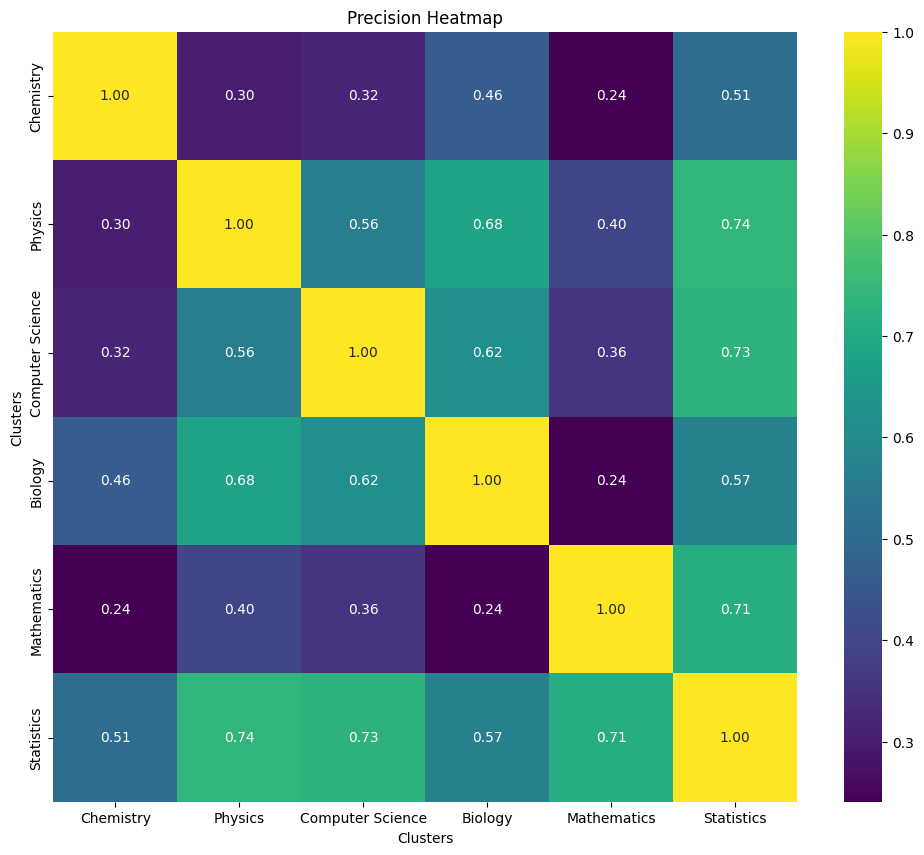

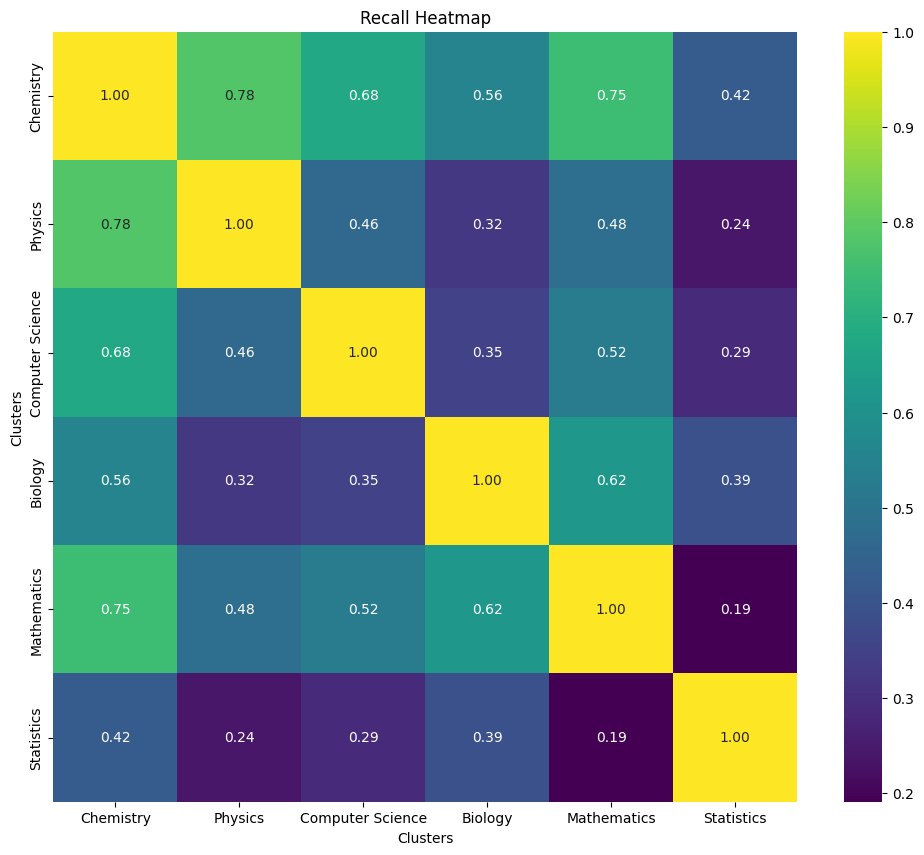

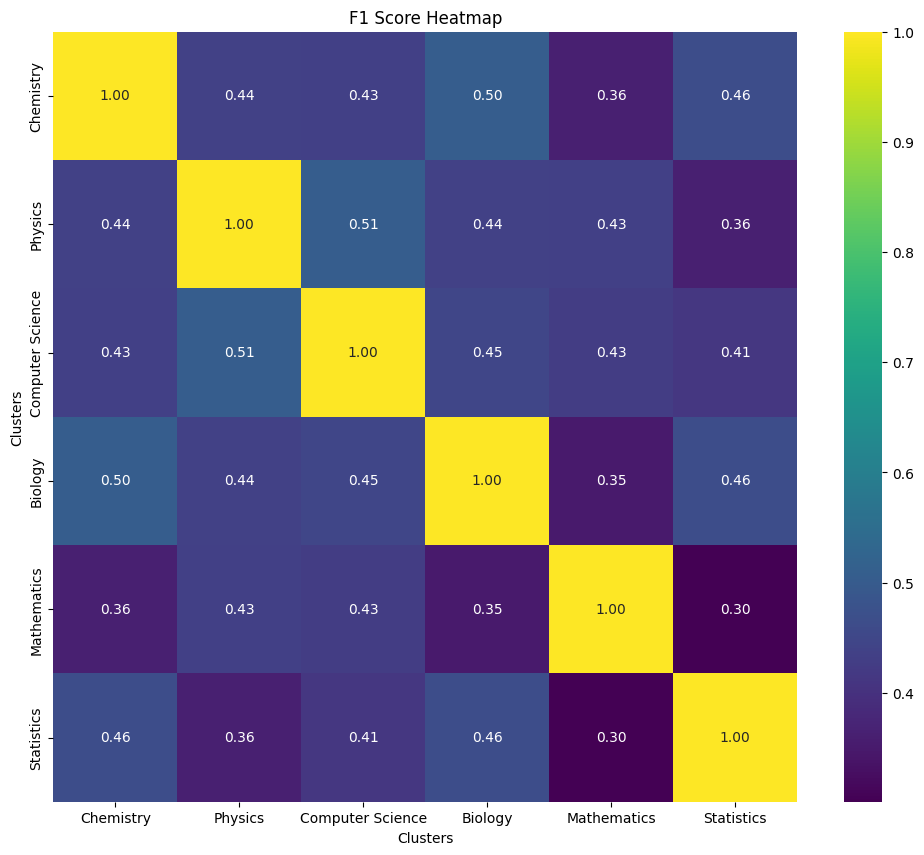

In [24]:


clusters, precision_matrix, recall_matrix, f1_matrix = prepare_heatmap_data(precision_recall_f1_stats)

plot_heatmap(precision_matrix, 'Precision Heatmap', 'Clusters', 'Clusters', clusters, clusters)
plot_heatmap(recall_matrix, 'Recall Heatmap', 'Clusters', 'Clusters', clusters, clusters)
plot_heatmap(f1_matrix, 'F1 Score Heatmap', 'Clusters', 'Clusters', clusters, clusters)